# PINN

La idea de este proyecto es implementar una red neuronal informada por la física (PINN) que se ajuste a la ecuación diferencial
$$
\begin{cases}
    -\Delta u + \alpha u = f, & x \in (0,π)\\
    u = g, & x \in \{0,π\}
\end{cases}
$$
donde  f  y  g  son funciones dadas.

## Preparación

Lo primero que debemos hacer es instalar e importar las librerías necesarias.

In [ ]:
pip install keras-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras

Using TensorFlow backend


Como necesitamos precisión se establece una semilla aleatoria en Keras, lo que garantiza que las operaciones aleatorias sean reproducibles. Esto significa que cada vez que se ejecute el código, las operaciones aleatorias producirán los mismos resultados, lo que facilita la depuración y la comparación de diferentes ejecuciones del modelo.

In [ ]:
keras.utils.set_random_seed(1234)

Ahora se configura Keras para utilizar float64 como el tipo de datos predeterminado para todas las operaciones de punto flotante. Esto asegura que todas las capas y operaciones en el modelo utilicen la precisión doble, lo que puede ser necesario para ciertos problemas que requieren una mayor precisión numérica.

In [ ]:
dtype='float64'
keras.backend.set_floatx(dtype)

Definamos de una vez los parámetros específicos del problema

In [ ]:
alpha = 1
limInf= 0
limSup = np.pi

Se definen también los parámetros para las redes de ambos planteamientos.

In [ ]:
# Número de neuronas por capa oculta en la red neuronal
neurons = 10
# Número de capas ocultas
nLayers = 4
# Número de puntos de integración
nPts = 1000
# Número de iteraciones de entrenamiento
iterations = 1000

# Factores de peso para las condiciones de frontera (planteamiento 1)
lambda0 = 2
lambda1 = 5
lambda2 = 8

## Planteamiento 1

El  primer  planteamiento  utiliza  la  función  de  pérdida  de  mínimos  cuadrados, incluyendo  las condiciones de frontera directamente en la función de pérdida. Esto significa que la función de pérdida calcula tanto el error de la ecuación diferencial parcial (PDE) como el error de las condiciones de frontera.

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
+ \lambda_1 \left( u_{NN}(0) - g(0) \right)^2
+ \lambda_2 \left( u_{NN}(1) - g(1) \right)^2
$$

En donde $\lambda_1$ y $\lambda_2$ son parámetros.

Creamos una función que contenga el modelo de red neuronal utilizando Keras para aproximar la solución de una ecuación diferencial parcial (EDP):

In [ ]:
def makeModel1(neurons, nLayers, activation):
    """
    Crea un modelo de red neuronal para aproximar la solución de la EDP.

    Args:
        neurons (int): Número de neuronas en cada capa oculta.
        nLayers (int): Número de capas ocultas.
        activation (str, opcional): Función de activación para las capas ocultas.

    Returns:
        keras.Model: Un modelo de red neuronal para la solución aproximada.
    """

    # Input layer
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Hidden layer
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)
    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)

    # Output layer
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')

    return uModel

Veamos los detalles de este modelo:

In [ ]:
uModel1 = makeModel1(neurons=neurons, nLayers=nLayers, activation='tanh')

# Imprimir la información del modelo u
uModel1.summary()

Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ x_input (InputLayer)               │ (None, 1)                     │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_20 (Dense)                   │ (None, 10)                    │          20 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_21 (Dense)                   │ (None, 10)                    │         110 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_22 (Dense)                   │ (None, 10)                    │         110 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_23 (Dense)                   │ (None, 1)                     │          11 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Sigue definir una capa personalizada en Keras que calcule la pérdida para las Redes Neuronales Informadas por Física (PINNs).

In [ ]:
class Loss1(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, lambda0 = 1,lambda1=1, lambda2=1, limInf=0, limSup=np.pi, **kwargs):
        """
        Inicializa la capa de pérdida de PINNs con los parámetros proporcionados.

        Args:
            u_model (keras.Model): El modelo de red neuronal para la solución aproximada.
            n_pts (int): Número de puntos de integración.
            f (función): Fuente - RHS de la PDE
            lambda0 (float): Factor de peso para la ecuación diferencial parcial (PDE)
            lambda1 (float): Factor de peso para la condición de frontera 1.
            lambda2 (float): Factor de peso para la condición de frontera 2.
            limInf (float): Límite inferior del dominio.
            limSup (float): Límite superior del dominio.

            kwargs: Argumentos adicionales.
        """
        super(Loss1, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.lambda0 = lambda0
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.limInf = limInf
        self.limSup = limSup

    def call(self, inputs):
        """
        Calcula la pérdida de colación - PINNs.

        Args:
            inputs: Los datos de entrada (dummy).

        Returns:
            keras.Tensor: El valor de la pérdida.
        """
        # Generar puntos de integración aleatorios
        x = tf.random.uniform([self.nPts], self.limInf, self.limSup, dtype=dtype)

        # Tomar gradientes (parte basada en tf)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)

        # Pérdida de PDE
        errorPDE = self.lambda0*keras.ops.mean((duxx + alpha * u - self.f(x)) ** 2)

        # Pérdida de BC de Dirichlet
        bc = self.lambda1 * self.uModel(np.array([self.limInf])) ** 2 + self.lambda2 * self.uModel(np.array([self.limSup])) ** 2
        return errorPDE + bc

Definimos la función makeLossModel. El propósito de esta función es construir un modelo de pérdida que se puede utilizar para entrenar la PINN. Este modelo de pérdida calcula el error de la solución aproximada de la PDE utilizando puntos de integración aleatorios y la función de pérdida definida en la clase Loss.

In [ ]:
def makeLossModel1(uModel, nPts, f,lambda0=1, lambda1=1, lambda2=1, limInf=0, limSup=np.pi):
    """
    Construye un modelo de pérdida para PINNs.

    Args:
        uModel (keras.Model): El modelo de red neuronal para la solución aproximada.
        nPts (int): Número de puntos de integración.
        f (función): Fuente - RHS de la PDE
        lambda0 (float): Factor de peso para la ecuación diferencial parcial (PDE)
        lambda1 (float): Factor de peso para la condición de frontera 1.
        lambda2 (float): Factor de peso para la condición de frontera 2.
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo con la función de pérdida basada en colación.
    """
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Calcular la pérdida utilizando la red neuronal proporcionada y
    # los parámetros de integración
    output = Loss1(uModel, nPts, f,lambda0, lambda1, lambda2, limInf, limSup)(xVals)

    # Crear un modelo de Keras para la pérdida
    lossModel = keras.Model(inputs=xVals, outputs=output)

    return lossModel

Definimos la función trickyLoss. El propósito de esta función es actuar como un marcador de posición para la función de pérdida. En un escenario real, esta función se sustituiría por una función de pérdida personalizada que calcule la diferencia entre los valores predichos (yPred) y los valores verdaderos (yTrue). La función de pérdida es crucial para el entrenamiento de modelos de aprendizaje automático, ya que guía el proceso de optimización ajustando los pesos del modelo para minimizar el error.

In [ ]:
def trickyLoss(yPred, yTrue):
    """
    Una función de pérdida de marcador de posición que se puede reemplazar según sea necesario.

    Args:
        yPred: Valores predichos.
        yTrue: Valores verdaderos.

    Returns:
        float: El valor de la pérdida.
    """
    # Esta es una función de pérdida de marcador de posición que se puede sustituir por una
    # pérdida personalizada si es necesario.
    return yTrue

## Planteamiento 2

El  segundo  planteamiento  propone  una  solución  para  el  caso  en  que  la  frontera cumple  $g = 0$, en donde

$$
u_{NN} = NN(x) \cdot x \cdot (x - π)
$$

Con función de pérdida  

$$
\mathcal{L}(u_{NN}) = \frac{1}{N} \sum_{i=1}^{N} \left( -\Delta u_{NN}(x_i) + \alpha u_{NN}(x_i) - f(x_i) \right)^2
$$

Aquí las condiciones de frontera se manejan dentro del modelo de red neuronal en lugar de la función de pérdida. Esto se logra mediante el uso de una capa Lambda que ajusta la salida del modelo para cumplir con las condiciones de frontera.


In [ ]:
def makeModel2(neurons, nLayers, activation, limInf=0, limSup=np.pi):
    """
    Crea un modelo de red neuronal para aproximar la solución de la EDP.

    Args:
        neurons (int): Número de neuronas en cada capa oculta.
        nLayers (int): Número de capas ocultas.
        activation (str, opcional): Función de activación para las capas ocultas.
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo de red neuronal para la solución aproximada.
    """

    # Input layers
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Hidden layers
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xVals)

    for l in range(nLayers - 2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)

    # Output layers (hasta la penúltima capa)
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    # Layer en donde se pone información de los términos de frontera (capa Lambda).
    boundaryC = keras.layers.Lambda(lambda x: (x-limInf)*(x-limSup))(xVals)

    # También hay que añadir una capa Multiply para manejar las condiciones de frontera.
    # Aqui se multiplica la red de capas densas con los términos que relacionan las condiciones de frontera
    output = keras.layers.Multiply()([output, boundaryC])

    uModel = keras.Model(inputs=xVals, outputs=output, name='u_model')

    return uModel

Veamos los detalles de este modelo:

In [ ]:
uModel2 = makeModel2(neurons=neurons, nLayers=nLayers, activation='tanh', limInf=limInf, limSup=limSup)

# Imprimir la información del modelo u
uModel2.summary()

Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)      │ (None, 1)              │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_24 (Dense)          │ (None, 10)             │         20 │ x_input[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_25 (Dense)          │ (None, 10)             │        110 │ dense_24[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_26 (Dense)          │ (None, 10)             │        110 │ dense_25[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_27 (Dense)          │ (None, 1)              │         11 │ dense_26[0][0]             │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │          0 │ x_input[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 1)              │          0 │ dense_27[0][0],            │
│                           │                        │            │ lambda_2[0][0]             │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class Loss2(keras.layers.Layer):
    def __init__(self, uModel, nPts, f, limInf=0, limSup=np.pi, **kwargs):
        """
        Inicializa la capa de pérdida de PINNs con los parámetros proporcionados.

        Args:
            u_model (keras.Model): El modelo de red neuronal para la solución aproximada.
            n_pts (int): Número de puntos de integración.
            f (función): Fuente - RHS de la PDE
            limInf (float): Límite inferior del dominio.
            limSup (float): Límite superior del dominio.

            kwargs: Argumentos adicionales.
        """
        super(Loss2, self).__init__()
        self.uModel = uModel
        self.nPts = nPts
        self.f = f
        self.limInf = limInf
        self.limSup = limSup


    def call(self, inputs):
        """
        Calcula la pérdida de colación - PINNs.

        Args:
            inputs: Los datos de entrada (dummy).

        Returns:
            keras.Tensor: El valor de la pérdida.
        """
        # Generar puntos de integración aleatorios
        x = tf.random.uniform([self.nPts], dtype=dtype, minval=self.limInf, maxval=self.limSup)

        # Tomar gradientes (parte basada en tf)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.uModel(x, training=True)
            dux = t2.gradient(u, x)
        duxx = t1.gradient(dux, x)

        # Pérdida de PDE
        errorPDE = keras.ops.mean((duxx + alpha * u - self.f(x)) ** 2)

        return errorPDE

In [ ]:
def makeLossModel2(uModel, nPts, f, limInf=0, limSup=np.pi):
    """
    Construye un modelo de pérdida para PINNs.

    Args:
        uModel (keras.Model): El modelo de red neuronal para la solución aproximada.
        nPts (int): Número de puntos de integración.
        f (función): Fuente - RHS de la PDE
        limInf (float): Límite inferior del dominio.
        limSup (float): Límite superior del dominio.

    Returns:
        keras.Model: Un modelo con la función de pérdida basada en colación.
    """
    xVals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Calcular la pérdida utilizando la red neuronal proporcionada y
    # los parámetros de integración
    output = Loss2(uModel, nPts, f, limInf, limSup)(xVals)

    # Crear un modelo de Keras para la pérdida
    lossModel = keras.Model(inputs=xVals, outputs=output)

    return lossModel

No es necesario definir otra función para trickyLoss

## Ejemplos

Primero definimos la función f (RHS), que es el término fuente en el lado derecho de la ecuación diferencial parcial (PDE) que se está resolviendo con la red neuronal informada por física (PINN).

In [ ]:
# PDE RHS
def fRhs(x):
    return (alpha - 4) * keras.ops.sin(2 * x)

# Definir la solución exacta
def exactU(x):
    return keras.ops.sin(2 * x)

Y hacemos una función para graficar los resultados.

In [ ]:
def plotResults(uModel, history, exactU, xList):
    """
    Función para graficar la solución aproximada y la evolución de la pérdida.

    Args:
        uModel (keras.Model): El modelo de red neuronal entrenado.
        history (keras.callbacks.History): La historia del entrenamiento.
        exactU (func): Función solución exacta.
        xList (numpy.ndarray): Lista de valores x para la visualización.
    """
    # Configuración de los parámetros de la gráfica
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 18
    rcParams['legend.fontsize'] = 17
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize'] = 19

    fig, ax = plt.subplots()
    # Graficar la solución aproximada obtenida del modelo entrenado
    plt.plot(xList, uModel(xList), color='b')
    plt.plot(xList, exactU(xList), color='m')

    plt.legend(['u_approx', 'u_exact'])

    ax.grid(which='both', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    # Graficar la evolución de la pérdida durante el entrenamiento
    plt.plot(history.history['loss'], color='r')

    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.legend(['loss'])

    ax.grid(which='major', axis='both', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

    # Aquí también debería graficar el error o loss vs error.

### Ej. planteamiento 1

Ahora entrenamos los modelos.

In [ ]:
# Gran modelo incluyendo la pérdida
lossModel1 = makeLossModel1(uModel1, nPts, fRhs, lambda0, lambda1, lambda2, limInf, limSup)

# Optimizador (optimizador Adam con una tasa de aprendizaje específica)
optimizer = keras.optimizers.Adam(learning_rate=10**-3)

# Compilar el modelo de pérdida con una función de pérdida personalizada (trickyLoss)
lossModel1.compile(optimizer=optimizer, loss=trickyLoss)

# Entrenar el modelo utilizando un único punto de datos de entrenamiento ([1.], [1.]) para un
# número especificado de épocas (iteraciones)
history1 = lossModel1.fit(np.array([1.]), np.array([1.]), epochs=iterations)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9280
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.7359
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.7030
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.6786
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.6876
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7011
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.6819
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.6593
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.6182
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6240
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.5835
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.5881
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.5761
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.5918
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss:

Y graficamos los resultados

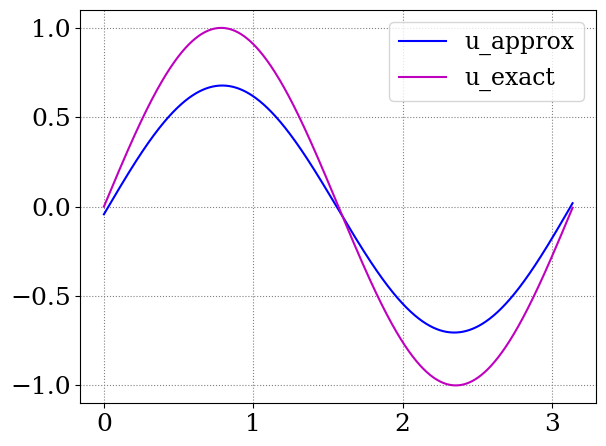

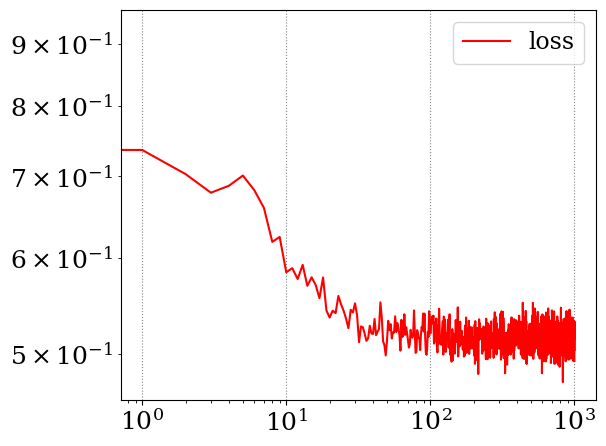

In [ ]:
# Generar una lista de valores x para la visualización
xList = np.array([np.pi / 1000 * i for i in range(1000)])

# Llamar a la función para graficar los resultados
plotResults(uModel1, history1, exactU, xList)

### Ej. planteamiento 2

Entrenamos el modelo

In [ ]:
# Gran modelo incluyendo la pérdida
lossModel2 = makeLossModel2(uModel2, nPts, fRhs)

# Optimizador (optimizador Adam con una tasa de aprendizaje específica)
optimizer2 = keras.optimizers.Adam(learning_rate=10**-3)

# Compilar el modelo de pérdida con una función de pérdida personalizada (trickyLoss)
lossModel2.compile(optimizer=optimizer2, loss=trickyLoss)

# Entrenar el modelo utilizando un único punto de datos de entrenamiento ([1.], [1.]) para un
# número especificado de épocas (iteraciones)
history2 = lossModel2.fit(np.array([1.]), np.array([1.]), epochs=iterations)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3224
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.3203
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3173
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3200
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3131
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.3149
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3264
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3105
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3169
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3074
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3115
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3166
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3059
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3228
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss:

Graficamos los resultados

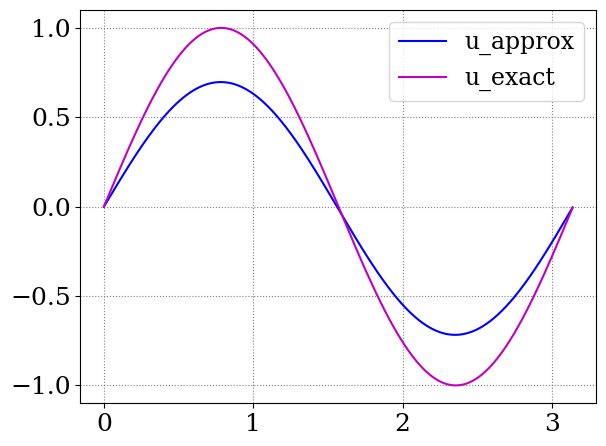

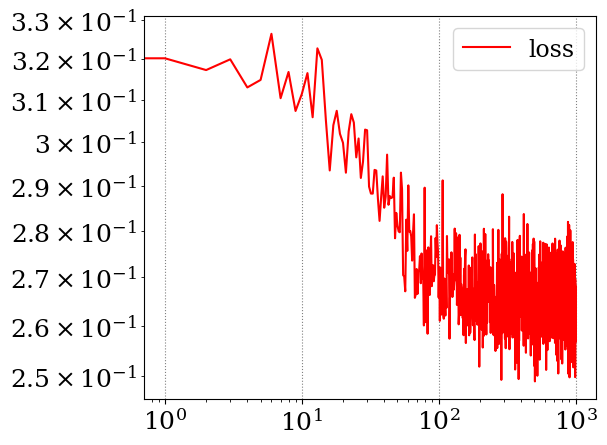

In [ ]:
# Definir la solución exacta
def exactU(x):
    return keras.ops.sin(2 * x)

# Generar una lista de valores x para la visualización
xList = np.array([np.pi / 1000 * i for i in range(1000)])

plotResults(uModel2, history2, exactU, xList)

## Pruebas

Probemos con diferentes funciones de activación. (no lo volví a correr porque se demora mucho)

In [ ]:
# Funciones de activación a probar
activations = ['tanh', 'relu', 'swish', 'elu', 'selu']

# Probar cada función de activación
for activation in activations:
    print(f'Training with activation: {activation}')
    uModelX = makeModel1(neurons=nn, nLayers=nl, activation=activation)
    lossModelX = makeLossModel1(uModelX, nPts, fRhs)
    optimizer = keras.optimizers.Adam(learning_rate=10**-3)
    lossModelX.compile(optimizer=optimizer, loss=trickyLoss)
    history = lossModelX.fit(np.array([1.]), np.array([1.]), epochs=iterations)
    plotResults(uModelX, history, exactU, xList)

La mejor es tanh

Nos interesa saber para qué número de iteraciones la mejora es insignificante, para eso probemos a usar callbacks, en este caso EarlyStopping que va a parar el modelo cuando no haya un cambio significativo en cierto número de iteraciones que podemos definir y que en este caso va a ser 500.

Epoch 1/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.9152
Epoch 2/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.9796
Epoch 3/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.8775
Epoch 4/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.1183
Epoch 5/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.8805
Epoch 6/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.9730
Epoch 7/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.4424
Epoch 8/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 7.8344
Epoch 9/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.6582
Epoch 10/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.7875
Epoch 11/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.8601
Epoch 12/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.8134
Epoch 13/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.5738
Epoch 14/1000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.3821
Epoch 15/1000000
1/1 ━━━━━━━━━━

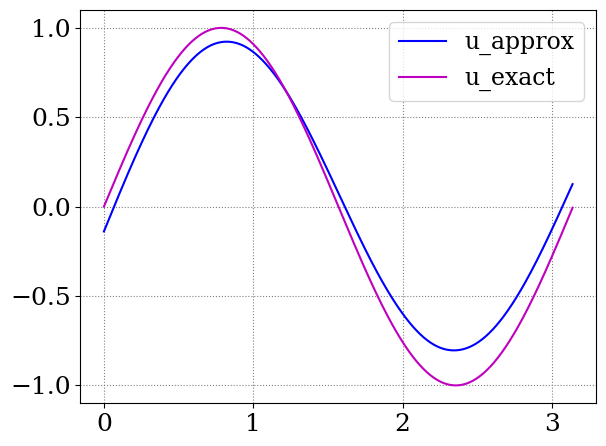

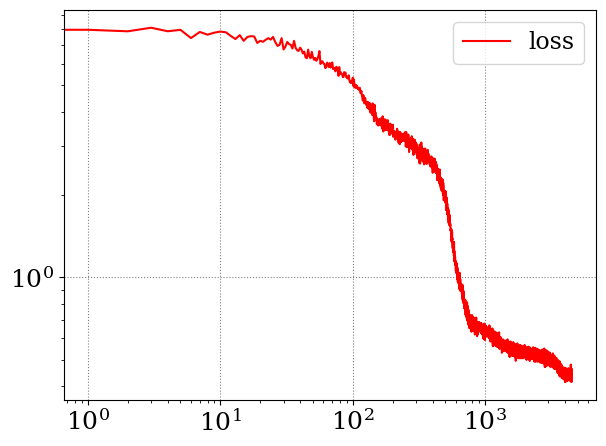

In [ ]:
# Definir los callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=500, restore_best_weights=True),
]

uModelCB = makeModel1(neurons=nn, nLayers=nl, activation='tanh')

# Gran modelo incluyendo la pérdida
lossModelCB1 = makeLossModel1(uModelCB, nPts, fRhs)

# Optimizador (optimizador Adam con una tasa de aprendizaje específica)
optimizer = keras.optimizers.Adam(learning_rate=10**-3)

# Compilar el modelo de pérdida con una función de pérdida personalizada (trickyLoss)
lossModelCB1.compile(optimizer=optimizer, loss=trickyLoss)

# Entrenar el modelo utilizando un único punto de datos de entrenamiento ([1.], [1.]) para un
# número especificado de épocas (iteraciones)
historyCB1 = lossModelCB1.fit(np.array([1.]), np.array([1.]), epochs=1000000, callbacks=callbacks)

plotResults(uModelCB, historyCB1, exactU, xList)

## Lo que falta:

- Que función de funciones funcione.
- Función error L^2.